# Creation of synthetic data for a stroke thrombolysis pathway data set using a variational autoencoder. Tested using a logistic regression model.

## Aim

To test a Variational Auto Ecencoder for synthesising data that can be used to train a logistic regression machine learning model

## Data

Raw data is avilable at: 

https://raw.githubusercontent.com/MichaelAllen1966/1807_stroke_pathway/master/machine_learning/data/data_for_ml_clin_only.csv

## Basic methods description

* Create synthetic data by use of a Variational AutoEncoder. A variational Auto Encoder encodes original data in a lower dimension space. An auto encoder will structure the network such that the decoded data, after dimensionality reduction, will have minumim loss compared to the original data. A variational autoencoder synthesis data by sampling values for the latent encoded data, coupled with regularisation of the training of the latent encoded layer to prevent over-fitting to the original data. 

![](../images/autoencoder_schema.png)

Auoencoder schema (from https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

Kingma, D.P. and  Welling, M. (2013) Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114,2013.

* Train logistic regression model on synthetic data and test against held-back raw data.

## Code & results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Turn warnings off for notebook publication
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Function to turn an array of float values into one-hot

In [3]:
def make_one_hot(x):
    """
    Takes a list/array/series and returns 1 for highest value and 0 for all 
    others
    
    """
    # Get argmax
    highest = np.argmax(x)
    # Set all values to zero
    x *= 0.0
    # Set argmax to one
    x[highest] = 1.0
    
    return x

### Import Data

In [4]:
def load_data():
    """"
    Load Stroke Pathway data set
    
    Inputs
    ------
    None
    
    Returns
    -------
    X: NumPy array of X
    y: Numpy array of y
    col_names: column names for X
    """    
    
    # Load data 
    data = pd.read_csv('./stroke_pathway.csv')
    
    # Shuffle data
    data = data.sample(frac=1)   

    # Change 'Thrombolysis given' column to 'thrombolysis', and put last
    data['label'] = data['Thrombolysis given']
    data.drop('Thrombolysis given', axis=1, inplace=True)

    # Split data in X and y
    X = data.drop(['label'], axis=1)
    y = data['label']
    
    # Get col names and convert to NumPy arrays
    X_col_names = list(X)
    X = X.values
    y = y.values
    
    return data, X, y, X_col_names 

### Data processing

Split X and y into training and test sets

In [5]:
def split_into_train_test(X, y, test_proportion=0.25):    
    """"
    Randomly split X and y numpy arrays into training and test data sets
    
    Inputs
    ------
    X and y NumPy arrays
    
    Returns
    -------
    X_test, X_train, y_test, y_train Numpy arrays
    """
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, shuffle=True, test_size=test_proportion)
        
    return X_train, X_test, y_train, y_test  

Standardise data

In [6]:
def standardise_data(X_train, X_test):
    """"
    Standardise training and tets data sets according to mean and standard
    deviation of test set
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    X_train_std, X_test_std
    """
    
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    X_train_std = (X_train - mu) / std
    X_test_std = (X_test - mu) /std
    
    return X_train_std, X_test_std
    

### Calculate accuracy measures

In [7]:
def calculate_diagnostic_performance(actual, predicted):
    """ Calculate sensitivty and specificty.
    
    Inputs
    ------
    actual, predted numpy arrays (1 = +ve, 0 = -ve)
    
    Returns
    -------
    A dictionary of results:
    
    1)  accuracy: proportion of test results that are correct    
    2)  sensitivity: proportion of true +ve identified
    3)  specificity: proportion of true -ve identified
    4)  positive likelihood: increased probability of true +ve if test +ve
    5)  negative likelihood: reduced probability of true +ve if test -ve
    6)  false positive rate: proportion of false +ves in true -ve patients
    7)  false negative rate:  proportion of false -ves in true +ve patients
    8)  positive predictive value: chance of true +ve if test +ve
    9)  negative predictive value: chance of true -ve if test -ve
    10) actual positive rate: proportion of actual values that are +ve
    11) predicted positive rate: proportion of predicted vales that are +ve
    12) recall: same as sensitivity
    13) precision: the proportion of predicted +ve that are true +ve
    14) f1 = 2 * ((precision * recall) / (precision + recall))

    *false positive rate is the percentage of healthy individuals who 
    incorrectly receive a positive test result
    * alse neagtive rate is the percentage of diseased individuals who 
    incorrectly receive a negative test result
    
    """
    
    # Calculate results 
    actual_positives = actual == 1
    actual_negatives = actual == 0
    test_positives = predicted == 1
    test_negatives = predicted == 0
    test_correct = actual == predicted
    accuracy = test_correct.mean()
    true_positives = actual_positives & test_positives
    false_positives = actual_negatives & test_positives
    true_negatives = actual_negatives & test_negatives
    sensitivity = true_positives.sum() / actual_positives.sum()
    specificity = np.sum(true_negatives) / np.sum(actual_negatives)
    positive_likelihood = sensitivity / (1 - specificity)
    negative_likelihood = (1 - sensitivity) / specificity
    false_postive_rate = 1 - specificity
    false_negative_rate = 1 - sensitivity
    positive_predictive_value = true_positives.sum() / test_positives.sum()
    negative_predicitive_value = true_negatives.sum() / test_negatives.sum()
    actual_positive_rate = actual.mean()
    predicted_positive_rate = predicted.mean()
    recall = sensitivity
    precision = \
        true_positives.sum() / (true_positives.sum() + false_positives.sum())
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    # Add results to dictionary
    results = dict()
    results['accuracy'] = accuracy
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_postive_rate'] = false_postive_rate
    results['false_postive_rate'] = false_postive_rate
    results['false_negative_rate'] = false_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predicitive_value'] = negative_predicitive_value
    results['actual_positive_rate'] = actual_positive_rate
    results['predicted_positive_rate'] = predicted_positive_rate
    results['recall'] = recall
    results['precision'] = precision
    results['f1'] = f1
   
    return results

### Logistic Regression Model

In [8]:
def fit_and_test_logistic_regression_model(X_train, X_test, y_train, y_test):    
    """"
    Fit and test logistic regression model. 
    Return a dictionary of accuracy measures.
    Calls on `calculate_diagnostic_performance` to calculate results
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    A dictionary of accuracy results.
    """
    
    # Fit logistic regression model 
    lr = LogisticRegression(C=0.1)
    lr.fit(X_train,y_train)

    # Predict tets set labels
    y_pred = lr.predict(X_test_std)
    
    # Get accuracy results
    accuracy_results = calculate_diagnostic_performance(y_test, y_pred)
    
    return accuracy_results

### Synthetic Data Method - Variational AutoEncoder

In [9]:
def sampling(args):
    """
    Reparameterization trick by sampling from an isotropic unit Gaussian.
    Instead of sampling from Q(z|X), sample epsilon = N(0,I)
    z = z_mean + sqrt(var) * epsilon

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    from tensorflow.keras import backend as K
        
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    sample = z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    return sample

In [10]:
def make_synthetic_data_vae(X_original, y_original, 
                            batch_size=256,
                            latent_dim=20,
                            epochs=10000,
                            learning_rate=2e-5,
                            dropout=0.25,
                            number_of_samples=1000,
                            regularisation=1e-3):
    """
    Synthetic data generation.
    
    Inputs
    ------
    original_data: X, y numpy arrays
    number_of_samples: number of synthetic samples to generate
    n_components: number of principal components to use for data synthesis
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
    from tensorflow.keras import layers
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras import backend as K
    from tensorflow.keras.losses import mse
    
    # Normalise data
    X_min = np.min(X_original, axis=0)
    X_max = np.max(X_original, axis=0)
    X_range = X_max - X_min
    X = (X_original - X_min) / X_range    
    
    # network parameters
    input_shape = X_original.shape[1]
    intermediate_dim = X_original.shape[1]
   
    # Split the training data into positive and negative
    mask = y_original == 1
    X_train_pos = X[mask]
    mask = y_original == 0
    X_train_neg = X[mask]
    
    # Set up list for positive and negative synthetic data sets
    synthetic_X_sets = []
    
    # Run fit twice: once for positive label examples, the other for negative
    for training_set in [X_train_pos, X_train_neg]:
        
        # Clear Tensorflow
        K.clear_session()

        # VAE model = encoder + decoder
        # build encoder model
        inputs = layers.Input(shape=input_shape, name='encoder_input')
        
        encode_dense_1 = layers.Dense(
            intermediate_dim, activation='relu')(inputs)
        
        dropout_encoder_layer_1 = layers.Dropout(dropout)(encode_dense_1)
        
        encode_dense_2 = layers.Dense(
            intermediate_dim, activation='relu')(dropout_encoder_layer_1)
        
        z_mean = layers.Dense(latent_dim, name='z_mean')(encode_dense_2)
        
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(encode_dense_2)
    
        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = layers.Lambda(
            sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
        # instantiate encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
        # build decoder model
        latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
        
        decode_dense_1 = layers.Dense(
            intermediate_dim, activation='relu')(latent_inputs)
        
        dropout_decoder_layer_1 = layers.Dropout(dropout)(decode_dense_1)
        
        decode_dense_2 = layers.Dense(
            intermediate_dim, activation='relu')(dropout_decoder_layer_1)
        
        outputs = layers.Dense(input_shape)(decode_dense_2)
    
        # instantiate decoder model
        decoder = Model(latent_inputs, outputs, name='decoder')
    
        # instantiate VAE model
        outputs = decoder(encoder(inputs)[2])
        vae = Model(inputs, outputs, name='vae_mlp')
    
        # Define loss
        # reconstuction = error between original and regenerated
        # kl = 'regularisation' - depends on distance of mu and sigma from 
        #   standard normal dist
        
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= input_shape
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5 * regularisation
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)
        
        # Compile model        
        optimizer = Adam(lr=learning_rate)
        vae.compile(optimizer=optimizer)
                
        # Train the autoencoder
        vae.fit(training_set, 
                batch_size = batch_size,
                shuffle = True,
                epochs = epochs,
                verbose=0)
        
        # Produce synthetic data
        z_new = np.random.normal(size = (number_of_samples, latent_dim))
        reconst = decoder.predict(np.array(z_new))
        # Reverse normalisation
        reconst = X_min + (reconst * X_range)
        synthetic_X_sets.append(reconst)
        
        # Clear models
        K.clear_session()
        del encoder
        del decoder
        del vae
        
    # Combine data
    # Combine positive and negative and shuffle rows
    X_synthetic = np.concatenate(
            (synthetic_X_sets[0], synthetic_X_sets[1]), axis=0)
    
    y_synthetic_pos = np.ones((number_of_samples, 1))
    y_synthetic_neg = np.zeros((number_of_samples, 1))
    
    y_synthetic = np.concatenate((y_synthetic_pos, y_synthetic_neg), axis=0)
    
    # Randomise order of X, y
    synthetic = np.concatenate((X_synthetic, y_synthetic), axis=1)
    shuffle_index = np.random.permutation(np.arange(X_synthetic.shape[0]))
    synthetic = synthetic[shuffle_index]
    X_synthetic = synthetic[:,0:-1]
    y_synthetic = synthetic[:,-1]
                                                                   
    return X_synthetic, y_synthetic

### Main code

In [11]:
# Load data
original_data, X, y, X_col_names = load_data()

# Set up results DataFrame
results = pd.DataFrame()

In [12]:
# Set one hot columns

one_hot_cols = [[x for x in X_col_names if x[0:4] == 'Hosp'],
               [x for x in X_col_names if x[0:21] == 'Onset Time Known Type'],
               [x for x in X_col_names if x[0:21] == 'Stroke severity group'],
               [x for x in X_col_names if x[0:11] == 'Stroke Type'],
               [x for x in X_col_names if x[0:12] == 'Antiplatelet'],
               [x for x in X_col_names if x[0:22] == 'Anticoag before stroke']]

In [13]:
# Set integer and binary columns

integer_cols = ['Male',
                'Age',
                'Age_80',
                '# Comorbidities',
                '2+ comorbidotes',
                'Congestive HF',
                'Hypertension',
                'Atrial Fib',
                'Diabetes',
                'TIA',
                'Co-mordity',
                'S2RankinBeforeStroke',
                'S2NihssArrival',
                'S2NihssArrivalLocQuestions',
                'S2NihssArrivalLocCommands',
                'S2NihssArrivalBestGaze',
                'S2NihssArrivalVisual',
                'S2NihssArrivalFacialPalsy',
                'S2NihssArrivalMotorArmLeft',
                'S2NihssArrivalMotorArmRight',
                'S2NihssArrivalMotorLegLeft',
                'S2NihssArrivalMotorLegRight',
                'S2NihssArrivalLimbAtaxia',
                'S2NihssArrivalSensory',
                'S2NihssArrivalBestLanguage',
                'S2NihssArrivalDysarthria',
                'S2NihssArrivalExtinctionInattention']

binary_cols = ['Male',
                'Age_80',
                '2+ comorbidotes',
                'Congestive HF',
                'Hypertension',
                'Atrial Fib',
                'Diabetes',
                'TIA',
                'Co-mordity']

Fitting classification model to raw data

In [14]:
# Set number of replicate runs
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')
    
    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data    
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['raw_mean'] = accuracy_array.mean(axis=0)
results['raw_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)
results.index = accuracy_measure_names

1 2 3 4 5 

Fitting classification model to synthetic data

In [15]:
# Set number of replicate runs
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []
synthetic_data = []

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')

    X_synthetic, y_synthetic = \
        make_synthetic_data_vae(X, y)

    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data (using synthetic data)
    X_train_std, X_test_std = standardise_data(X_synthetic, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_synthetic, y_test)

    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)

     # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Save synthetic data set
    # -----------------------
    
    # Create a data frame with id
    synth_df = pd.DataFrame()
    
        # Transfer X values to DataFrame
    synth_df=pd.concat([synth_df, 
                        pd.DataFrame(X_synthetic, columns=X_col_names)],
                        axis=1)
    
    # Make one hot as necessary
    for one_hot_list in one_hot_cols:    
        for index, row in synth_df.iterrows():
            x = row[one_hot_list]
            x_one_hot = make_one_hot(x)
            row[x_one_hot.index]= x_one_hot.values
            
    # Make integer as necessary
    for col in integer_cols:
        synth_df[col] = synth_df[col].round(0)
        
    # Clip binary cols
    for col in binary_cols:
        synth_df[col] = np.clip(synth_df[col],0,1)

    # Add a label
    y_list = list(y_synthetic)
    synth_df['label'] = y_list

    # Shuffle data
    synth_df = synth_df.sample(frac=1.0)
    
    # Add to synthetic data results list
    synthetic_data.append(synth_df)
    

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['synthetic_mean'] = accuracy_array.mean(axis=0)
results['synthetic_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)

1 2 3 4 5 

### Show results

In [16]:
results

,raw_mean,raw_sem,synthetic_mean,synthetic_sem
accuracy,0.808584,0.006051,0.664378,0.004275
sensitivity,0.794557,0.010786,0.691847,0.030622
specificity,0.818373,0.006143,0.648001,0.019459
positive_likelihood,4.401370,0.169186,1.973333,0.042187
negative_likelihood,0.251172,0.013486,0.471219,0.032829
false_postive_rate,0.181627,0.006143,0.351999,0.019459
false_negative_rate,0.205443,0.010786,0.308153,0.030622
positive_predictive_value,0.750282,0.008907,0.568991,0.008431
negative_predicitive_value,0.853054,0.007021,0.760155,0.016875
actual_positive_rate,0.407296,0.003347,0.401288,0.006337


## Compare raw and synthetic data means and standard deviations

In [17]:
descriptive_stats_all_runs = []

for run in range(number_of_runs):
    
    synth_df = synthetic_data[run]
  
    descriptive_stats = pd.DataFrame()

    descriptive_stats['Original pos_label mean'] = \
        original_data[original_data['label'] == 1].mean()

    descriptive_stats['Synthetic pos_label mean'] = \
        synth_df[synth_df['label'] == 1].mean()

    descriptive_stats['Original neg_label mean'] = \
        original_data[original_data['label'] == 0].mean()

    descriptive_stats['Synthetic neg_label mean'] = \
        synth_df[synth_df['label'] == 0].mean()

    descriptive_stats['Original pos_label std'] = \
        original_data[original_data['label'] == 1].std()

    descriptive_stats['Synthetic pos_label std'] = \
        synth_df[synth_df['label'] == 1].std()

    descriptive_stats['Original neg_label std'] = \
        original_data[original_data['label'] == 0].std()

    descriptive_stats['Synthetic neg_label std'] = \
        synth_df[synth_df['label'] == 0].std()
    
    descriptive_stats_all_runs.append(descriptive_stats)

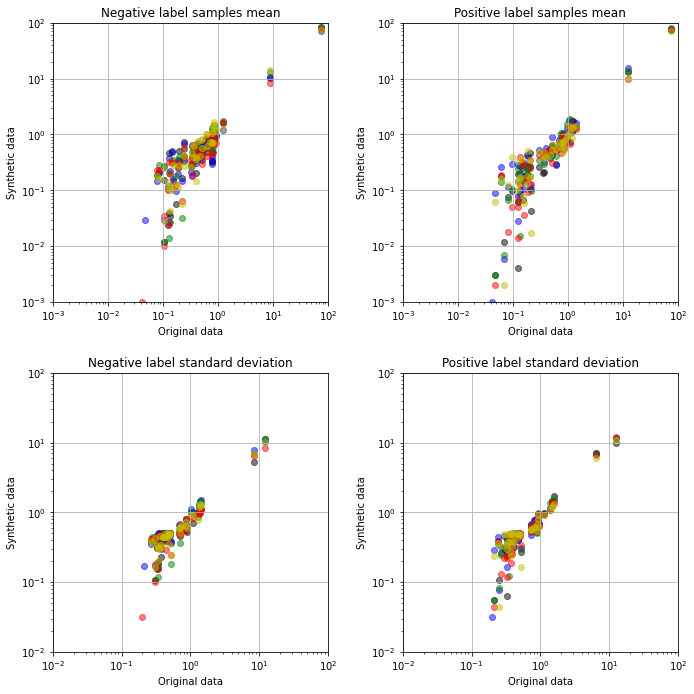

In [18]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,10))

# Note: Set x and y limits to avoid plotting values that are very close to zero

# Negative mean
ax1 = fig.add_subplot(221)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(x,y, color=colour, alpha=0.5)
ax1.set_xlabel('Original data')
ax1.set_ylabel('Synthetic data')
ax1.set_xlim(1e-3, 1e2)
ax1.set_ylim(1e-3, 1e2)
ax1.set_title('Negative label samples mean')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()

# Positive mean
ax2 = fig.add_subplot(222)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(x,y, color=colour, alpha=0.5)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Positive label samples mean')
ax2.set_xlim(1e-3, 1e2)
ax2.set_ylim(1e-3, 1e2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid()

# Negative standard deviation
ax3 = fig.add_subplot(223)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax3.scatter(x,y, color=colour, alpha=0.5)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('Negative label standard deviation')
ax3.set_xlim(1e-2, 1e2)
ax3.set_ylim(1e-2, 1e2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid()

# Positive standard deviation
ax4 = fig.add_subplot(224)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax4.scatter(x,y, color=colour, alpha=0.5)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Positive label standard deviation')
ax4.set_xlim(1e-2, 1e2)
ax4.set_ylim(1e-2, 1e2)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('Output/vae_correls.png', facecolor='w', dpi=300)
plt.show()

Calculate correlations between means and standard deviations for negative and positive classes.

In [19]:
correl_mean_neg = []
correl_std_neg = []
correl_mean_pos = []
correl_std_pos = []

for run in range(number_of_runs):
    # Get correlation of means
    x = descriptive_stats_all_runs[run]['Original neg_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean']
    correl_mean_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean']
    correl_mean_pos.append(np.corrcoef(x,y)[0,1])
    
    # Get correlation of standard deviations
    x = descriptive_stats_all_runs[run]['Original neg_label std']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std']
    correl_std_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label std']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std']
    correl_std_pos.append(np.corrcoef(x,y)[0,1])

# Get correlation of means
mean_r_square_mean_neg = np.mean(np.square(correl_mean_neg))
mean_r_square_mean_pos = np.mean(np.square(correl_mean_pos))
sem_square_mean_neg = np.std(np.square(correl_mean_neg))/np.sqrt(number_of_runs)
sem_square_mean_pos = np.std(np.square(correl_mean_pos))/np.sqrt(number_of_runs)

print ('R-square of means (negative), mean (std): ', end='')
print (f'{mean_r_square_mean_neg:0.3f} ({sem_square_mean_neg:0.3f})')
print ('R-square of means (positive), mean (std): ', end='')
print (f'{mean_r_square_mean_pos:0.3f} ({sem_square_mean_pos:0.3f})')

# Get correlation of standard deviations
mean_r_square_sd_neg = np.mean(np.square(correl_std_neg))
mean_r_square_sd_pos = np.mean(np.square(correl_std_pos))
sem_square_sd_neg = np.std(np.square(correl_std_neg))/np.sqrt(number_of_runs)
sem_square_sd_pos = np.std(np.square(correl_std_pos))/np.sqrt(number_of_runs)

print ('R-square of standard deviations (negative), mean (sem): ', end='')
print (f'{mean_r_square_sd_neg:0.3f} ({sem_square_sd_neg:0.3f})')
print ('R-square of standard deviations (positive), mean (sem): ', end='')
print (f'{mean_r_square_sd_pos:0.3f} ({sem_square_sd_pos:0.3f})')

R-square of means (negative), mean (std): 0.998 (0.001)
R-square of means (positive), mean (std): 0.999 (0.000)
R-square of standard deviations (negative), mean (sem): 0.987 (0.005)
R-square of standard deviations (positive), mean (sem): 0.989 (0.004)


## Single run example

In [20]:
descriptive_stats_all_runs[0]

,Original pos_label mean,Synthetic pos_label mean,Original neg_label mean,Synthetic neg_label mean,Original pos_label std,Synthetic pos_label std,Original neg_label std,Synthetic neg_label std
Hosp_1,0.203728,0.460,0.129613,0.039,0.403038,0.498647,0.336028,0.193692
Hosp_2,0.122503,0.063,0.155716,0.149,0.328085,0.243085,0.362749,0.356267
Hosp_3,0.182423,0.195,0.135914,0.034,0.386450,0.396399,0.342851,0.181320
Hosp_4,0.137150,0.086,0.184518,0.355,0.344235,0.280504,0.388081,0.478753
Hosp_5,0.067909,0.012,0.047705,0.000,0.251758,0.108940,0.213237,0.000000
Hosp_6,0.123835,0.004,0.106211,0.012,0.329613,0.063151,0.308246,0.108940
Hosp_7,0.162450,0.180,0.240324,0.411,0.369109,0.384380,0.427473,0.492261
Male,0.515313,0.652,0.515752,0.630,0.500099,0.476574,0.499977,0.483046
Age,73.303595,73.257,75.398740,83.799,12.563268,9.929731,12.017943,11.112429
Age_80,0.346205,0.207,0.393339,0.620,0.476077,0.405358,0.488711,0.485629


## Correlation between features

Here we calculate a correlation matric between all features for original and synthetic data.

In [21]:
neg_correlation_original = []
neg_correlation_synthetic = []
pos_correlation_original = []
pos_correlation_synthetic = []

correl_coeff_neg = []
correl_coeff_pos= []

# Original data
mask = original_data['label'] == 0
neg_o = original_data[mask].copy()
neg_o.drop('label', axis=1, inplace=True)
neg_correlation_original = neg_o.corr().values.flatten()

mask = original_data['label'] == 1
pos_o = original_data[mask].copy()
pos_o.drop('label', axis=1, inplace=True)
pos_correlation_original = pos_o.corr().values.flatten()

# Synthetic data
for i in range (number_of_runs):
    data_s = synthetic_data[i]
    
    mask = data_s['label'] == 0
    neg_s = data_s[mask].copy()
    neg_s.drop('label', axis=1, inplace=True)
    corr_neg_s = neg_s.corr().values.flatten()
    neg_correlation_synthetic.append(corr_neg_s)
    
    mask = data_s['label'] == 1
    pos_s = data_s[mask].copy()
    pos_s.drop('label', axis=1, inplace=True)
    corr_pos_s = pos_s.corr().values.flatten()
    pos_correlation_synthetic.append(corr_pos_s)

    # Get correlation coefficients
    df = pd.DataFrame()
    df['original'] = neg_correlation_original
    df['synthetic'] = corr_neg_s    
    correl_coeff_neg.append(df.corr().loc['original']['synthetic'])    
    
    df = pd.DataFrame()
    df['original'] = pos_correlation_original
    df['synthetic'] = corr_pos_s
    correl_coeff_pos.append(df.corr().loc['original']['synthetic']) 

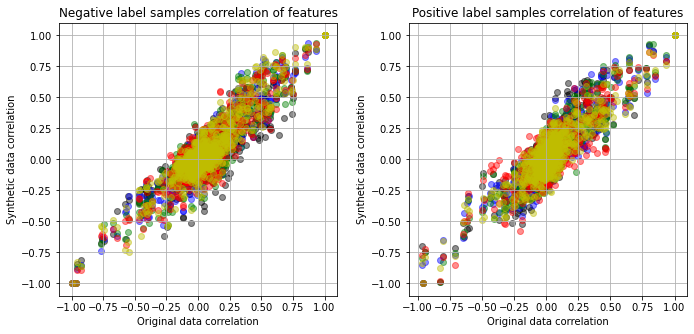

In [22]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(
        neg_correlation_original,
        neg_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax1.grid()
ax1.set_xlabel('Original data correlation')
ax1.set_ylabel('Synthetic data correlation')
ax1.set_title('Negative label samples correlation of features')

ax2 = fig.add_subplot(122)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(
        pos_correlation_original,
        pos_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax2.grid()
ax2.set_xlabel('Original data correlation')
ax2.set_ylabel('Synthetic data correlation')
ax2.set_title('Positive label samples correlation of features')

plt.tight_layout(pad=2)
plt.savefig('Output/vae_cov.png', facecolor='w', dpi=300)
plt.show()

In [23]:
r_square_neg_mean = np.mean(np.square(correl_coeff_neg))
r_square_pos_mean = np.mean(np.square(correl_coeff_pos))
r_square_neg_sem = np.std(np.square(correl_coeff_neg))/np.sqrt(number_of_runs)
r_square_pos_sem = np.std(np.square(correl_coeff_pos))/np.sqrt(number_of_runs)

print ('Corrleation of correlations (negative), mean (sem): ', end='')
print (f'{r_square_neg_mean:0.3f} ({r_square_neg_sem:0.3f})')
print ('Corrleation of correlations (positive), mean (sem): ', end = '')
print (f'{r_square_pos_mean:0.3f} ({r_square_pos_sem:0.3f})')

Corrleation of correlations (negative), mean (sem): 0.844 (0.008)
Corrleation of correlations (positive), mean (sem): 0.827 (0.006)
